# Setup

In [22]:
import pandas as pd
import numpy as np

from eval_funcs import (
        perplexity_for_corpora,
        wasserstein_distance_embeddings,
        classify_real_vs_synth,
        compute_stat_properties,
        compute_opt_embeddings
    )

# Import Real Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\loren\.cache\kagglehub\datasets\gowrishankarp\newspaper-text-summarization-cnn-dailymail\versions\2


In [3]:
cnn_train = pd.read_csv(r'C:\Users\loren\.cache\kagglehub\datasets\gowrishankarp\newspaper-text-summarization-cnn-dailymail\versions\2\cnn_dailymail\train.csv')

In [4]:
cnn_train.head(2)

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...


# Import Qwen Synthetic Dataset

In [5]:
qwen_data = pd.read_csv('../qwen_outputs.csv').drop('Unnamed: 0', axis=1)

In [6]:
qwen_data.head(2)

,uuid,generated_article
0,76cf2ce8-d643-4882-9c66-b0ee34921f30,On the heels of an exciting announcement made ...
1,91383ee7-7098-4b30-9837-078d80f4a22d,"After months of speculation and anticipation, ..."


In [7]:
qwen_data['generated_article'].shape

(101,)

In [8]:
qwen_data['generated_article'].str.split(' ').transform(lambda x: len(x)).max()

93

# Run Eval Functions

### Running Statistical Properties Metrics on Qwen Data

In [9]:
stats = compute_stat_properties(qwen_data['generated_article'], max_length=4096)

In [10]:
stats

{'avg_len_tokens': 98.38613891601562,
 'std_len_tokens': 17.234533309936523,
 'avg_len_chars': 499.5049504950495,
 'ttr': 0.2461507497232565,
 'hapax_ratio': 0.5723630417007359}

### Running Perplexity Scores

In [11]:
ppl = perplexity_for_corpora(cnn_train['article'].sample(1000, random_state=42), qwen_data['generated_article'], batch_size=8, max_length=2048)

[perplexity] device=cuda batch_size=8 max_length(requested)=2048 max_length(effective)=2048
[perplexity] num_docs: real=1000 synthetic=101 total_batches=138


c:\Users\loren\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\opt\modeling_opt.py:341: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


[perplexity] progress 5/138 | elapsed=5.3s | avg/batch=1.06s | ETA~140.5s
[perplexity] progress 10/138 | elapsed=10.4s | avg/batch=1.04s | ETA~133.7s
[perplexity] progress 15/138 | elapsed=16.0s | avg/batch=1.07s | ETA~131.2s
[perplexity] progress 20/138 | elapsed=20.8s | avg/batch=1.04s | ETA~122.7s
[perplexity] progress 25/138 | elapsed=27.8s | avg/batch=1.11s | ETA~125.7s
[perplexity] progress 30/138 | elapsed=31.5s | avg/batch=1.05s | ETA~113.5s
[perplexity] progress 35/138 | elapsed=36.5s | avg/batch=1.04s | ETA~107.3s
[perplexity] progress 40/138 | elapsed=41.5s | avg/batch=1.04s | ETA~101.7s
[perplexity] progress 45/138 | elapsed=46.7s | avg/batch=1.04s | ETA~96.4s
[perplexity] progress 50/138 | elapsed=53.4s | avg/batch=1.07s | ETA~94.0s
[perplexity] progress 55/138 | elapsed=60.7s | avg/batch=1.10s | ETA~91.6s
[perplexity] progress 60/138 | elapsed=65.6s | avg/batch=1.09s | ETA~85.2s
[perplexity] progress 65/138 | elapsed=71.7s | avg/batch=1.10s | ETA~80.5s
[perplexity] progre

In [12]:
ppl

{'real': {'corpus_ppl': 20.093418953077368},
 'synthetic': {'corpus_ppl': 12.678989529393954}}

### Running Wasserstein Distance

In [13]:
wd = wasserstein_distance_embeddings(cnn_train['article'].sample(1000, random_state=42), qwen_data['generated_article'], n_projections=128)

[embed:real] device=cuda batch_size=8 max_length(req)=2048 max_length(eff)=2048 num_docs=1000
[embed:real] progress 5/125 | elapsed=2.6s | avg/batch=0.51s | ETA~61.5s
[embed:real] progress 10/125 | elapsed=5.1s | avg/batch=0.51s | ETA~58.2s
[embed:real] progress 15/125 | elapsed=7.9s | avg/batch=0.53s | ETA~58.1s
[embed:real] progress 20/125 | elapsed=10.3s | avg/batch=0.51s | ETA~54.1s
[embed:real] progress 25/125 | elapsed=13.0s | avg/batch=0.52s | ETA~52.0s
[embed:real] progress 30/125 | elapsed=15.2s | avg/batch=0.51s | ETA~48.1s
[embed:real] progress 35/125 | elapsed=17.6s | avg/batch=0.50s | ETA~45.3s
[embed:real] progress 40/125 | elapsed=20.1s | avg/batch=0.50s | ETA~42.7s
[embed:real] progress 45/125 | elapsed=22.5s | avg/batch=0.50s | ETA~40.0s
[embed:real] progress 50/125 | elapsed=25.6s | avg/batch=0.51s | ETA~38.3s
[embed:real] progress 55/125 | elapsed=28.5s | avg/batch=0.52s | ETA~36.3s
[embed:real] progress 60/125 | elapsed=31.0s | avg/batch=0.52s | ETA~33.6s
[embed:rea

In [14]:
wd

{'mean_distance': 0.1754817853084636,
 'distances': [0.18745513366972422,
  0.14598681857958232,
  0.2647285609030934,
  0.07092813550971705,
  0.06595181668070935,
  0.08001212131011085,
  0.1638978366051832,
  0.032011756626778576,
  0.09561747852303956,
  0.04385074999452358,
  0.09545290092560695,
  0.4539369885799016,
  0.10798190580041733,
  0.44340380138096797,
  0.21425143731368404,
  0.047210485189537625,
  0.11369957531706237,
  0.2164603829391168,
  0.20256588387143215,
  0.07253471971400977,
  0.07094524011981769,
  0.5615995554566193,
  0.09803822852840821,
  0.07971651071770311,
  0.12684985765429302,
  0.11343795493611152,
  0.27418056124015056,
  0.09484841310295028,
  0.12574369263331092,
  0.14704891761780167,
  0.16418479522732427,
  0.14269163204930008,
  0.17838298817873988,
  0.20032150333058057,
  0.41100786474190554,
  0.23807484508305982,
  0.05817908948415079,
  0.09767768707413207,
  0.057594464890568894,
  0.2893252371533661,
  0.1981032149420528,
  0.185352

### Runnning Classification (Real vs. Synthetic)

In [15]:
clf_res = classify_real_vs_synth(cnn_train['article'].sample(1000, random_state=42), qwen_data['generated_article'], cv=5)

[classify] batch_size=8 max_length=2048 cv=5 Cs=[0.1, 0.5, 1.0, 2.0, 5.0]
[embed:real] device=cuda batch_size=8 max_length(req)=2048 max_length(eff)=2048 num_docs=1000
[embed:real] progress 5/125 | elapsed=2.5s | avg/batch=0.51s | ETA~60.9s
[embed:real] progress 10/125 | elapsed=5.1s | avg/batch=0.51s | ETA~59.2s
[embed:real] progress 15/125 | elapsed=8.1s | avg/batch=0.54s | ETA~59.3s
[embed:real] progress 20/125 | elapsed=10.5s | avg/batch=0.53s | ETA~55.3s
[embed:real] progress 25/125 | elapsed=13.3s | avg/batch=0.53s | ETA~53.1s
[embed:real] progress 30/125 | elapsed=15.5s | avg/batch=0.52s | ETA~49.0s
[embed:real] progress 35/125 | elapsed=17.9s | avg/batch=0.51s | ETA~46.1s
[embed:real] progress 40/125 | elapsed=20.5s | avg/batch=0.51s | ETA~43.5s
[embed:real] progress 45/125 | elapsed=22.9s | avg/batch=0.51s | ETA~40.7s
[embed:real] progress 50/125 | elapsed=25.9s | avg/batch=0.52s | ETA~38.9s
[embed:real] progress 55/125 | elapsed=28.9s | avg/batch=0.53s | ETA~36.8s
[embed:real

In [16]:
clf_res

{'metrics': {'accuracy': 0.9864253393665159,
  'macro_f1': 0.9578163771712159,
  'roc_auc': 0.9995024875621891},
 'report': {'real': {'precision': 0.9900990099009901,
   'recall': 0.9950248756218906,
   'f1-score': 0.9925558312655087,
   'support': 201.0},
  'synthetic': {'precision': 0.9473684210526315,
   'recall': 0.9,
   'f1-score': 0.9230769230769231,
   'support': 20.0},
  'accuracy': 0.9864253393665159,
  'macro avg': {'precision': 0.9687337154768108,
   'recall': 0.9475124378109453,
   'f1-score': 0.9578163771712159,
   'support': 221.0},
  'weighted avg': {'precision': 0.986231988285754,
   'recall': 0.9864253393665159,
   'f1-score': 0.9862681472665416,
   'support': 221.0}},
 'embeddings_shape': (1101, 768),
 'classifier': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregressioncv',
                  LogisticRegressionCV(Cs=[0.1, 0.5, 1.0, 2.0, 5.0], cv=5,
                                       max_iter=5000, n_jobs=-1,
                    

# Data Quality Visualizations

Article Length

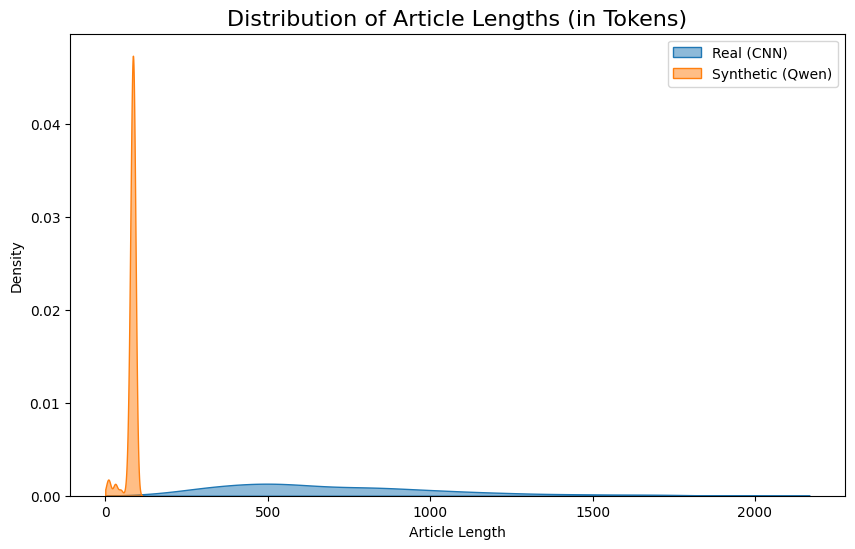

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample real data to match synthetic data size
real_texts = cnn_train['article'].sample(1000, random_state=42)
synth_texts = qwen_data['generated_article']

len_real = real_texts.str.split().str.len()
len_synth = synth_texts.str.split().str.len()

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(len_real, label='Real (CNN)', fill=True, alpha=0.5, clip=(0, 4000))
sns.kdeplot(len_synth, label='Synthetic (Qwen)', fill=True, alpha=0.5, clip=(0, 4000))

plt.title('Distribution of Article Lengths (in Tokens)', fontsize=16)
plt.xlabel('Article Length')
plt.ylabel('Density')
plt.legend()
plt.savefig('article_length_distribution.png')
plt.show();

Perplexity

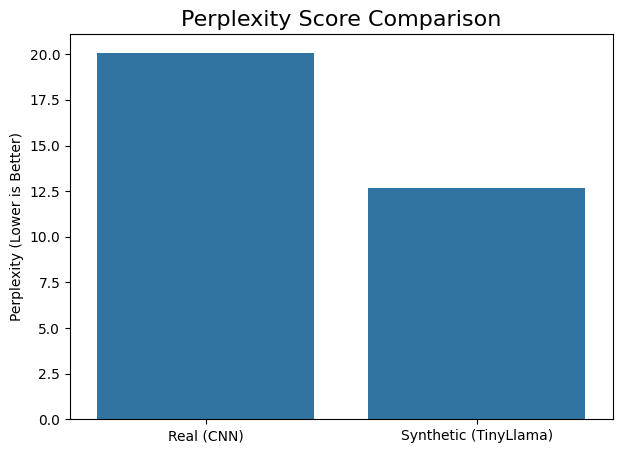

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the data from your 'ppl' variable
ppl_scores = {
    'Real (CNN)': ppl['real']['corpus_ppl'],
    'Synthetic (TinyLlama)': ppl['synthetic']['corpus_ppl']
}

# 2. Create the plot
plt.figure(figsize=(7, 5))
sns.barplot(x=list(ppl_scores.keys()), y=list(ppl_scores.values()))

plt.title('Perplexity Score Comparison', fontsize=16)
plt.ylabel('Perplexity (Lower is Better)')
plt.savefig('perplexity_comparison.png')
plt.show();

Wasserstein Distance

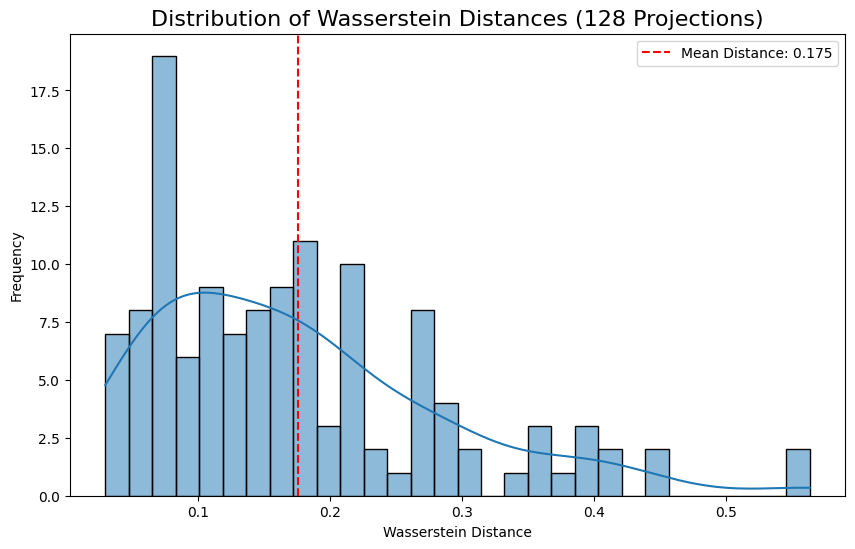

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get data from 'wd'
distances = wd['distances']
mean_dist = wd['mean_distance']

# Create plot
plt.figure(figsize=(10, 6))
sns.histplot(distances, bins=30, kde=True)

plt.axvline(mean_dist, color='red', linestyle='--', label=f'Mean Distance: {mean_dist:.3f}')
plt.title('Distribution of Wasserstein Distances (128 Projections)', fontsize=16)
plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('wasserstein_distance_distribution.png')
plt.show();

Classifier: t-SNE Plot of Real vs. Synthetic Embeddings

Computing embeddings for REAL texts (for t-SNE)...
[embed:real_tsne] device=cuda batch_size=8 max_length(req)=2048 max_length(eff)=2048 num_docs=1000
[embed:real_tsne] progress 5/125 | elapsed=2.5s | avg/batch=0.51s | ETA~61.1s
[embed:real_tsne] progress 10/125 | elapsed=5.1s | avg/batch=0.51s | ETA~58.6s
[embed:real_tsne] progress 15/125 | elapsed=8.0s | avg/batch=0.53s | ETA~58.4s
[embed:real_tsne] progress 20/125 | elapsed=10.4s | avg/batch=0.52s | ETA~54.4s
[embed:real_tsne] progress 25/125 | elapsed=13.2s | avg/batch=0.53s | ETA~52.7s
[embed:real_tsne] progress 30/125 | elapsed=15.5s | avg/batch=0.52s | ETA~49.0s
[embed:real_tsne] progress 35/125 | elapsed=18.0s | avg/batch=0.51s | ETA~46.2s
[embed:real_tsne] progress 40/125 | elapsed=20.6s | avg/batch=0.51s | ETA~43.7s
[embed:real_tsne] progress 45/125 | elapsed=23.1s | avg/batch=0.51s | ETA~41.1s
[embed:real_tsne] progress 50/125 | elapsed=26.3s | avg/batch=0.53s | ETA~39.4s
[embed:real_tsne] progress 55/125 | elapsed=29.3s | av

c:\Users\loren\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


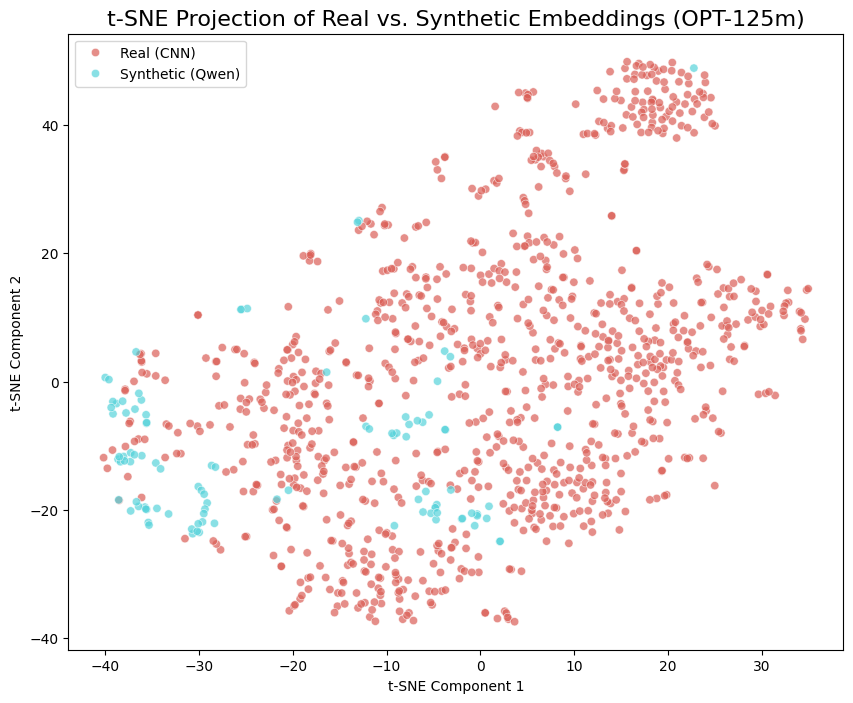

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# Compute embeddings

real_texts = cnn_train['article'].sample(1000, random_state=42)
synth_texts = qwen_data['generated_article']

print("Computing embeddings for REAL texts (for t-SNE)...")
Er = compute_opt_embeddings(
    real_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="real_tsne"
)

print("\nComputing embeddings for SYNTHETIC texts (for t-SNE)...")
Es = compute_opt_embeddings(
    synth_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="synth_tsne"
)

# Combine embeddings and create labels
embeddings = np.concatenate([Er, Es], axis=0)
labels = ['Real (CNN)'] * len(Er) + ['Synthetic (Qwen)'] * len(Es)

print(f"\nRunning t-SNE on {embeddings.shape[0]} embeddings")

# Reduce 768 dimensions down to 2
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)

# Create dataframe and plot

df_tsne = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'label': labels
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=df_tsne,
    alpha=0.7
)

plt.title('t-SNE Projection of Real vs. Synthetic Embeddings (OPT-125m)', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')
plt.savefig('tsne_embeddings.png')
plt.show();